## Lo-Fi Solution for the Adding Problem using RNNs

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [2]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm

from sequence_addition.data import get_adding_problem_data
from sequence_addition.rnn import create_model
from sequence_addition.visualization import (plot_loss_curves, significant_digits,
                                             plot_loss_vs_seq_length, pred_vs_true_plot)

sns.set(font_scale=1.25)
sns.set_style("whitegrid")

The goal is to train sequence models to be able to correctly sum up two numbers out of a long sequence of random float values. The two numbers are indicated by a second binary feature. The challenge is that the models may have to remember the respective values over many time steps depending on the sequence length.

Thus we investigate training and test performance and how it relates to sequence lengths.

The adding problem is discussed in detail in _A Simple Way to Initialize Recurrent Networks of Rectified Linear Units_ by Le et al. This implementation was developed with limited computing ressources so we demonstrate the approach with fewer training samples, shorter sequences and fewer training epochs compared to the paper. It should be adaptable to larger data sets and more computing power straightforwardly.

In [3]:
np.random.seed(1)
tf.random.set_seed(1)

SEQ_LENGTHS = [50, 100, 150, 200]
NUM_SAMPLES = 15000
NUM_SAMPLES_TEST = 1000

We generate Training and test sets for each sequence length. A validation split is done on-the-fly using the keras API. We train all models with the same number of samples and epochs. On model evaluation, we store loss values and quantiles of the predictions in the `results` object for visualization below.

In [4]:
results = []

for seq_length in SEQ_LENGTHS:
    print('#' * 100)
    print(f'\033[1mSequence length {seq_length}\033[0m with {NUM_SAMPLES} train/val samples '
          f'and {NUM_SAMPLES_TEST} test samples', flush=True)
    X, Y = get_adding_problem_data(seq_length=seq_length, num_samples=NUM_SAMPLES)

    model, history = create_model(X, Y)
    
    X_test, Y_test = get_adding_problem_data(seq_length=seq_length, num_samples=NUM_SAMPLES_TEST)
    test_loss = model.evaluate(X_test, Y_test, verbose=0)
    pred_test = model.predict(X_test)
    df = pd.DataFrame({'pred_sum': pd.Series(pred_test.ravel()),
                       'true_sum': pd.Series(Y_test.ravel())})
    df['qcuts'] = pd.qcut(df.pred_sum, 20)
    quantiles = df.groupby('qcuts').mean()
        
    res = {
        'seq_length': seq_length,
        'model': model,
        'history': history,
        'test_loss': test_loss,
        'quantiles': quantiles
    }
    results.append(res)
    sys.stderr.flush()
    print(f'Test loss={significant_digits(test_loss, n=3)}\n', flush=True)


####################################################################################################
Sequence length 50 with 15000 train/val samples and 1000 test samples


Create data: 100%|████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2135.52it/s]


Test loss=0.000890

####################################################################################################
Sequence length 100 with 15000 train/val samples and 1000 test samples


Create data: 100%|████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2163.39it/s]


Test loss=0.0104

####################################################################################################
Sequence length 150 with 15000 train/val samples and 1000 test samples


Create data: 100%|████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2425.85it/s]


Test loss=0.0263

####################################################################################################
Sequence length 200 with 15000 train/val samples and 1000 test samples


Create data: 100%|████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1951.68it/s]


Test loss=0.168



### Results

We observe that the training converges to rather low loss values (MSE) for the sequences with lengths 50, 100, and 150. The model performance for sequence length 200 is poor, however.

The fact that the scores for the independent test sets are similar to the scores of the training and validation sets indicates that the models do not overfit. The training curves are shown below.

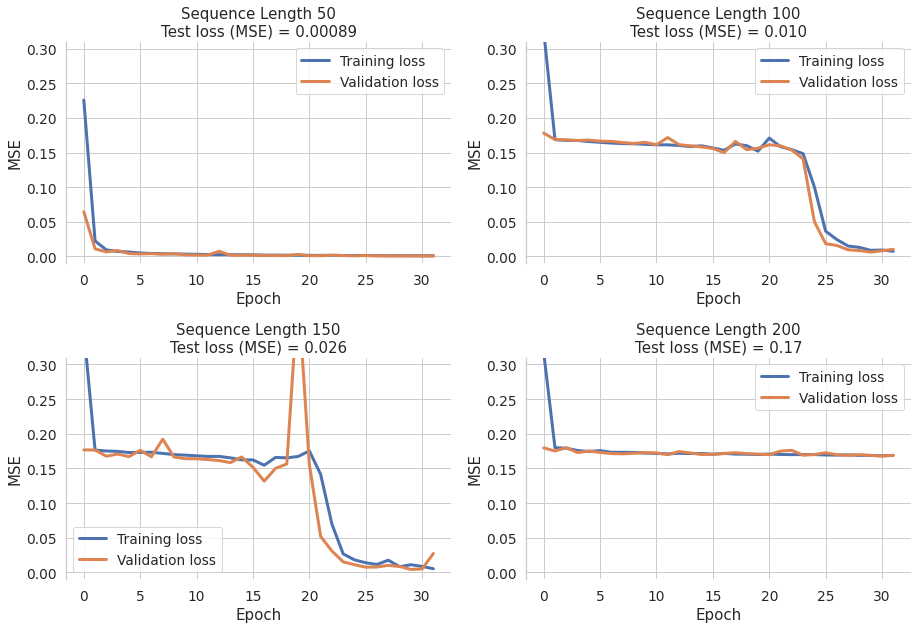

In [5]:
plt.figure(figsize=(13, 9))

for i, res in enumerate(results):
    ax = plt.subplot(2, 2, i + 1)

    plot_loss_curves(res, ax)

plt.tight_layout()
plt.show()

#### Performance <-> Sequence Length

When we focus on the test loss exclusively we can clearly see the dependency of the model performance on the sequence length. For the first 3 results it increases slightly while the loss of >0.15 indicates that the model training failed for sequence length 200.

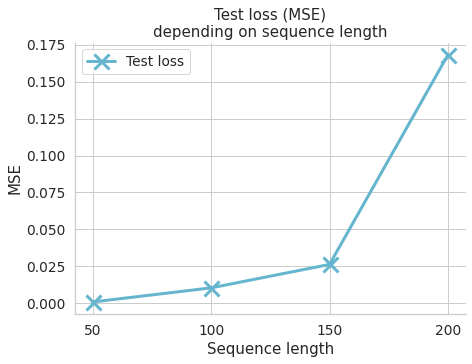

In [6]:
plt.figure(figsize=(7, 5))
plot_loss_vs_seq_length(results)
plt.show()

#### Prediction Quantile Plots

We can observe systematic prediction errors using a Q-Q plot of predictions for the test sets. The comparison of predicted sums with true sums aligns nicely with the diagonal for sequence lengths 50 and 100. For sequence length 150 we see a slight underestimation of the model, most visible for values above 1.2. The Q-Q plot for sequence length 200 again reflects the fact that no useful model was found.

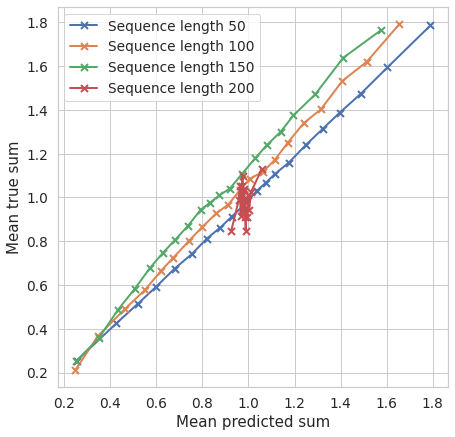

In [7]:
plt.figure(figsize=(7, 7))
pred_vs_true_plot(results)
plt.show()